# &#x1F4D1; &nbsp;  The Data Set of Flower Images

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron');
body {background-color: gainsboro;} 
a {color: #818286; font-family: Orbitron;} 
h1, h2 {color: #37c9e1; font-family: Orbitron; text-shadow: 4px 4px 4px #ccc;} 
h3, h4 {color: #818286; font-family: Orbitron; text-shadow: 4px 4px 4px #ccc;}
span {text-shadow: 4px 4px 4px #ccc;}        
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategray;}        
</style>

## &#x1F310; &nbsp; 0. Code Library and Links

In [2]:
import numpy as np 
import pandas as pd 

import cv2
import os
import scipy
import h5py
from six.moves import cPickle as pickle
from skimage import io

from PIL import ImageFile
from tqdm import tqdm

In [3]:
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

In [4]:
import keras
import tensorflow
print('keras version:', keras.__version__)
print('tensorflow version:', tensorflow.__version__)

Using TensorFlow backend.


keras version: 2.1.6
tensorflow version: 1.8.0


In [5]:
from keras.preprocessing import image as keras_image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input

from keras.callbacks import ModelCheckpoint

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GlobalAveragePooling1D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [7]:
def loss_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['loss'], label = 'train')
    plt.plot(fit_history.history['val_loss'], label = 'test')

    plt.legend()
    plt.title('Loss Function');  

def acc_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['acc'], label = 'train')
    plt.plot(fit_history.history['val_acc'], label = 'test')

    plt.legend()
    plt.title('Accuracy'); 
    
def path_to_tensor(img_path):
    img = keras_image.load_img("/Users/olgabelitskaya/cookbooks/flower_images/"+img_path, 
                               target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True                     

## &#x1F310; &nbsp; 1. Explore the Data

In [8]:
flowers = pd.read_csv("/Users/olgabelitskaya/cookbooks/flower_images/flower_labels.csv")
flower_files = flowers['file']
flower_targets = flowers['label'].values
flower_tensors = paths_to_tensor(flower_files);

100%|██████████| 210/210 [00:27<00:00,  7.53it/s]


In [9]:
flower_tensors.shape

(210, 128, 128, 3)

In [10]:
flower_targets.shape

(210,)

In [11]:
with h5py.File('FlowerColorImages.h5', 'w') as f:
    f.create_dataset('images', data = flower_tensors)
    f.create_dataset('labels', data = flower_targets)

In [12]:
pickle_file = 'FlowerColorImages.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {'images': flower_tensors, 'labels': flower_targets}
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 41289619


Label:  9


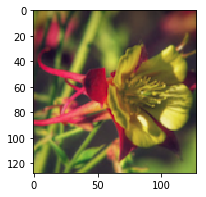

In [13]:
print('Label: ', flower_targets[168])
flower_image = cv2.imread('/Users/olgabelitskaya/cookbooks/flower_images/'+flower_files[168])
rgb_flower_image = cv2.cvtColor(flower_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(3,3))
plt.imshow(rgb_flower_image);

In [14]:
x_train, x_test, y_train, y_test = train_test_split(flower_tensors, flower_targets, 
                                                    test_size = 0.2, random_state = 1)
[x_train.shape, y_train.shape, x_test.shape, y_test.shape]

[(168, 128, 128, 3), (168,), (42, 128, 128, 3), (42,)]

In [15]:
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]
x_train.shape, x_test.shape, x_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((168, 128, 128, 3),
 (21, 128, 128, 3),
 (21, 128, 128, 3),
 (168,),
 (21,),
 (21,))

Label:  4


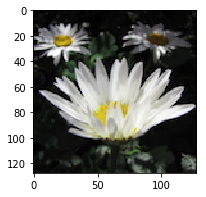

In [16]:
print('Label: ', y_train[1])
plt.figure(figsize=(3,3))
plt.imshow((x_train[1]/255).reshape(128,128,3));

In [17]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_valid = x_valid.astype('float32')/255

c_y_train = to_categorical(y_train, 10)
c_y_test = to_categorical(y_test, 10)
c_y_valid = to_categorical(y_valid, 10)

[x_train.shape, c_y_train.shape, x_test.shape, c_y_test.shape, x_valid.shape, c_y_valid.shape]

[(168, 128, 128, 3),
 (168, 10),
 (21, 128, 128, 3),
 (21, 10),
 (21, 128, 128, 3),
 (21, 10)]

## &#x1F310; &nbsp; 2. Models

In [38]:
# MLP
def mlp_mc_model():
    model = Sequential()
    
    model.add(Dense(128, activation='relu', input_shape=(128*128*3,)))
    model.add(BatchNormalization())
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.2))    
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mlp_mc_model = mlp_mc_model()

In [39]:
mlp_mc_checkpointer = ModelCheckpoint(filepath='weights.best.mlp_mc.flowers.hdf5', 
                                      verbose=2, save_best_only=True)
mlp_mc_history = mlp_mc_model.fit(x_train.reshape(-1, 128*128*3), c_y_train,
                                  validation_data=(x_valid.reshape(-1, 128*128*3), c_y_valid),
                                  epochs=50, batch_size=64, verbose=0, 
                                  callbacks=[mlp_mc_checkpointer])


Epoch 00001: val_loss improved from inf to 6.57058, saving model to weights.best.mlp_mc.flowers.hdf5

Epoch 00002: val_loss improved from 6.57058 to 3.17069, saving model to weights.best.mlp_mc.flowers.hdf5

Epoch 00003: val_loss improved from 3.17069 to 3.01145, saving model to weights.best.mlp_mc.flowers.hdf5

Epoch 00004: val_loss did not improve from 3.01145

Epoch 00005: val_loss did not improve from 3.01145

Epoch 00006: val_loss did not improve from 3.01145

Epoch 00007: val_loss improved from 3.01145 to 2.92765, saving model to weights.best.mlp_mc.flowers.hdf5

Epoch 00008: val_loss improved from 2.92765 to 2.74474, saving model to weights.best.mlp_mc.flowers.hdf5

Epoch 00009: val_loss improved from 2.74474 to 2.70149, saving model to weights.best.mlp_mc.flowers.hdf5

Epoch 00010: val_loss improved from 2.70149 to 2.64758, saving model to weights.best.mlp_mc.flowers.hdf5

Epoch 00011: val_loss improved from 2.64758 to 2.61890, saving model to weights.best.mlp_mc.flowers.hdf5


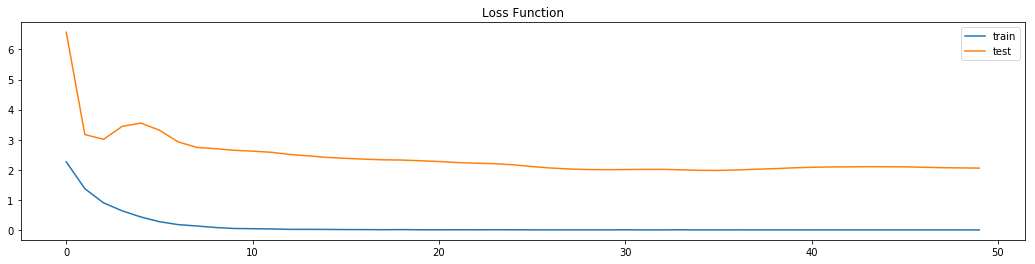

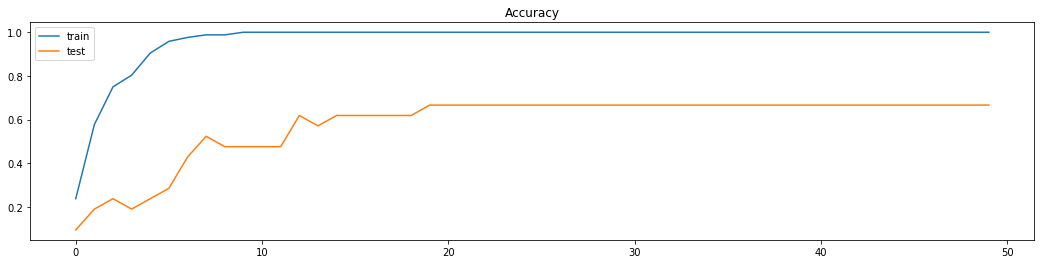

In [40]:
loss_plot(mlp_mc_history)
acc_plot(mlp_mc_history)

In [41]:
mlp_mc_model.load_weights('weights.best.mlp_mc.flowers.hdf5')
mlp_mc_test_score = mlp_mc_model.evaluate(x_test.reshape(-1, 128*128*3), c_y_test)
mlp_mc_test_score

21/21 [==============================] - 0s 1ms/step


[1.5433214902877808, 0.6190476417541504]

In [46]:
# CNN
def cnn_mc_model():
    model = Sequential()

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (5, 5)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

#     model.add(Flatten())
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(512, activation='tanh'))
    model.add(Dropout(0.25)) 
    
#    model.add(Dense(256, activation='tanh'))
#    model.add(Dropout(0.25)) 
    
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.25)) 

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cnn_mc_model = cnn_mc_model()

In [47]:
cnn_mc_checkpointer = ModelCheckpoint(filepath='weights.best.cnn_mc.flowers.hdf5', 
                                      verbose=2, save_best_only=True)
cnn_mc_history = cnn_mc_model.fit(x_train, c_y_train, 
                                  epochs=50, batch_size=64, verbose=2,
                                  validation_data=(x_valid, c_y_valid),
                                  callbacks=[cnn_mc_checkpointer])

Train on 168 samples, validate on 21 samples
Epoch 1/50
 - 18s - loss: 2.3992 - acc: 0.1131 - val_loss: 2.2861 - val_acc: 0.1429

Epoch 00001: val_loss improved from inf to 2.28614, saving model to weights.best.cnn_mc.flowers.hdf5
Epoch 2/50
 - 14s - loss: 2.2706 - acc: 0.1488 - val_loss: 2.2323 - val_acc: 0.1905

Epoch 00002: val_loss improved from 2.28614 to 2.23232, saving model to weights.best.cnn_mc.flowers.hdf5
Epoch 3/50
 - 17s - loss: 2.2109 - acc: 0.1488 - val_loss: 2.2249 - val_acc: 0.1905

Epoch 00003: val_loss improved from 2.23232 to 2.22490, saving model to weights.best.cnn_mc.flowers.hdf5
Epoch 4/50
 - 13s - loss: 2.0702 - acc: 0.2321 - val_loss: 2.0808 - val_acc: 0.1905

Epoch 00004: val_loss improved from 2.22490 to 2.08081, saving model to weights.best.cnn_mc.flowers.hdf5
Epoch 5/50
 - 13s - loss: 2.1550 - acc: 0.1488 - val_loss: 2.1396 - val_acc: 0.1905

Epoch 00005: val_loss did not improve from 2.08081
Epoch 6/50
 - 12s - loss: 1.8983 - acc: 0.2857 - val_loss: 2.07

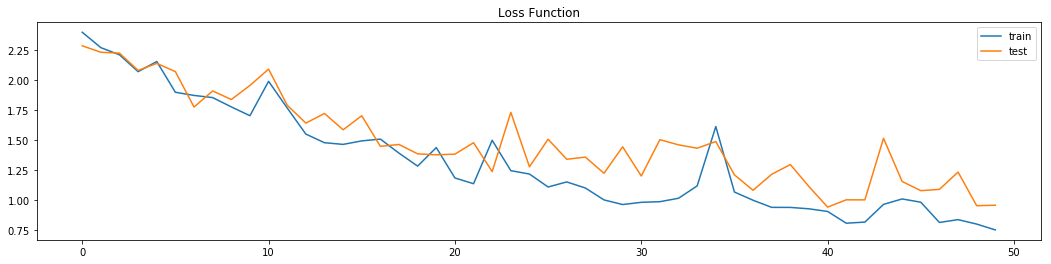

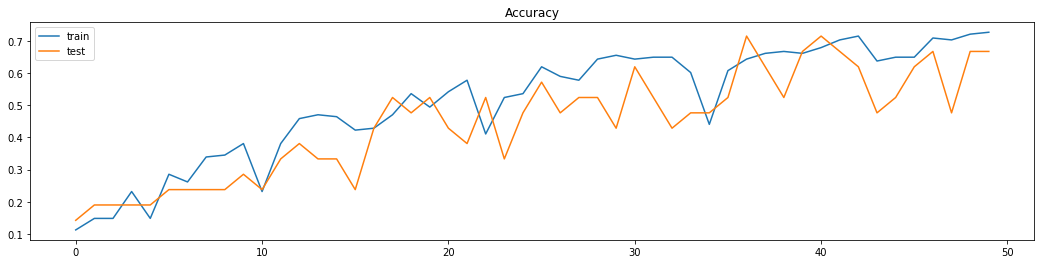

In [48]:
loss_plot(cnn_mc_history)
acc_plot(cnn_mc_history)

In [49]:
cnn_mc_model.load_weights('weights.best.cnn_mc.flowers.hdf5')
cnn_mc_test_score = cnn_mc_model.evaluate(x_test, c_y_test)
cnn_mc_test_score

21/21 [==============================] - 0s 22ms/step


[0.971106231212616, 0.6666666865348816]

In [50]:
data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)
cnn_mc_dg_history = cnn_mc_model.fit_generator(data_generator.flow(x_train, c_y_train, batch_size=64),
                                               steps_per_epoch = 189, epochs = 5, verbose=2, 
                                               validation_data = (x_valid, c_y_valid),
                                               callbacks=[cnn_mc_checkpointer])

Epoch 1/5
 - 752s - loss: 0.7075 - acc: 0.7476 - val_loss: 0.8383 - val_acc: 0.7143

Epoch 00001: val_loss improved from 0.94004 to 0.83829, saving model to weights.best.cnn_mc.flowers.hdf5
Epoch 2/5
 - 721s - loss: 0.4634 - acc: 0.8286 - val_loss: 0.6842 - val_acc: 0.8095

Epoch 00002: val_loss improved from 0.83829 to 0.68423, saving model to weights.best.cnn_mc.flowers.hdf5
Epoch 3/5
 - 707s - loss: 0.3450 - acc: 0.8752 - val_loss: 0.7894 - val_acc: 0.7619

Epoch 00003: val_loss did not improve from 0.68423
Epoch 4/5
 - 727s - loss: 0.2552 - acc: 0.9094 - val_loss: 1.0961 - val_acc: 0.7143

Epoch 00004: val_loss did not improve from 0.68423
Epoch 5/5
 - 703s - loss: 0.1506 - acc: 0.9483 - val_loss: 1.0202 - val_acc: 0.7619

Epoch 00005: val_loss did not improve from 0.68423


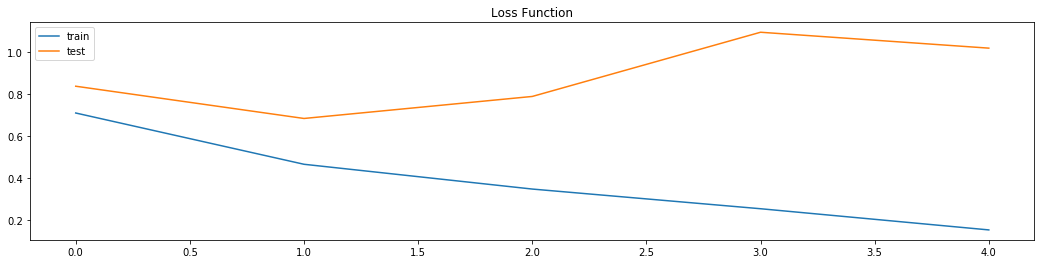

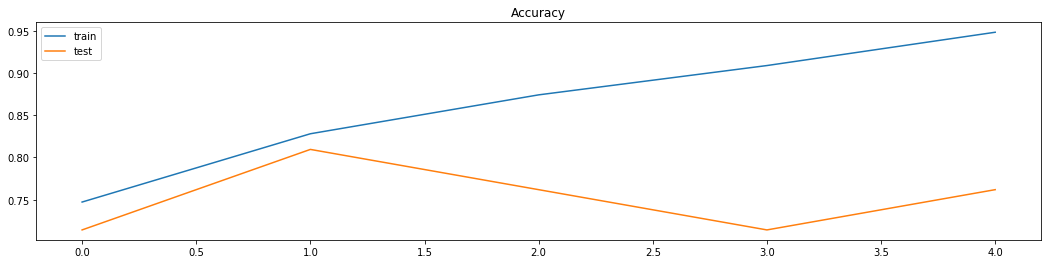

In [51]:
loss_plot(cnn_mc_dg_history)
acc_plot(cnn_mc_dg_history)

In [52]:
cnn_mc_model.load_weights('weights.best.cnn_mc.flowers.hdf5')
cnn_mc_dg_test_score = cnn_mc_model.evaluate(x_test, c_y_test)
cnn_mc_dg_test_score

21/21 [==============================] - 0s 22ms/step


[0.7551586031913757, 0.8095238208770752]

In [18]:
# RNN
def rnn_mc_model():
    model = Sequential()

    model.add(LSTM(128, return_sequences=True, input_shape=(1, 128*128*3))) 
#    model.add(LSTM(128, return_sequences=True))
    
    model.add(LSTM(128))  
    model.add(Dense(512, activation='relu'))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

rnn_mc_model = rnn_mc_model()

In [19]:
rnn_mc_checkpointer = ModelCheckpoint(filepath='weights.best.rnn_mc.flowers.hdf5', 
                                      verbose=2, save_best_only=True)
rnn_mc_history = rnn_mc_model.fit(x_train.reshape(-1,1,128*128*3), c_y_train, 
                                  epochs=30, batch_size=64, verbose=2,
                                  validation_data=(x_valid.reshape(-1,1,128*128*3), c_y_valid),
                                  callbacks=[rnn_mc_checkpointer])

Train on 168 samples, validate on 21 samples
Epoch 1/30
 - 28s - loss: 2.3015 - acc: 0.1071 - val_loss: 2.3016 - val_acc: 0.1429

Epoch 00001: val_loss improved from inf to 2.30157, saving model to weights.best.rnn_mc.flowers.hdf5
Epoch 2/30
 - 6s - loss: 2.2828 - acc: 0.1369 - val_loss: 2.2844 - val_acc: 0.1429

Epoch 00002: val_loss improved from 2.30157 to 2.28440, saving model to weights.best.rnn_mc.flowers.hdf5
Epoch 3/30
 - 4s - loss: 2.2482 - acc: 0.1310 - val_loss: 2.2484 - val_acc: 0.1429

Epoch 00003: val_loss improved from 2.28440 to 2.24844, saving model to weights.best.rnn_mc.flowers.hdf5
Epoch 4/30
 - 3s - loss: 2.2146 - acc: 0.1369 - val_loss: 2.2044 - val_acc: 0.1429

Epoch 00004: val_loss improved from 2.24844 to 2.20442, saving model to weights.best.rnn_mc.flowers.hdf5
Epoch 5/30
 - 6s - loss: 2.1556 - acc: 0.2143 - val_loss: 2.1787 - val_acc: 0.1905

Epoch 00005: val_loss improved from 2.20442 to 2.17874, saving model to weights.best.rnn_mc.flowers.hdf5
Epoch 6/30
 -

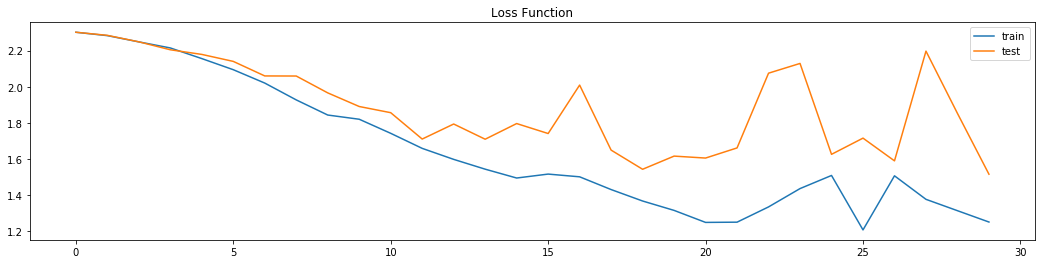

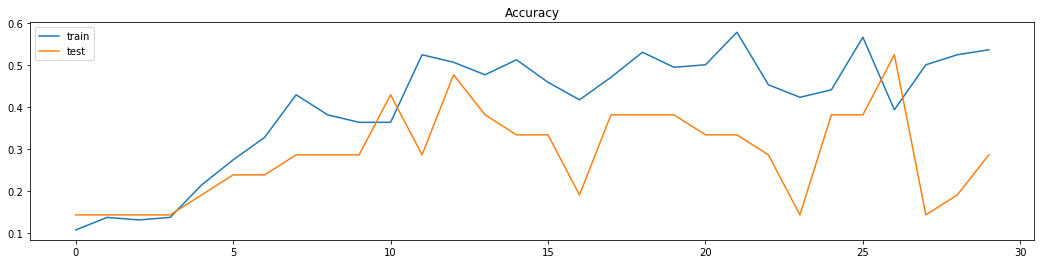

In [20]:
loss_plot(rnn_mc_history)
acc_plot(rnn_mc_history)

In [21]:
rnn_mc_model.load_weights('weights.best.rnn_mc.flowers.hdf5')
rnn_mc_test_score = rnn_mc_model.evaluate(x_test.reshape(-1,1,128*128*3), c_y_test)
rnn_mc_test_score

21/21 [==============================] - 0s 22ms/step


[2.260357141494751, 0.2857142984867096]

## &#x1F310; &nbsp; 3. Applications

In [79]:
# InceptionV3
iv3_base_model = InceptionV3(weights='imagenet', include_top=False)
x = iv3_base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)

y = Dense(10, activation='softmax')(x)

iv3_model = Model(inputs=iv3_base_model.input, outputs=y)

In [80]:
# Freeze InceptionV3 convolutional layers
for layer in iv3_base_model.layers:
    layer.trainable = False
    
iv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
steps, epochs = 150, 10
data_generator = keras_image.ImageDataGenerator(shear_range=0.2, 
                                                zoom_range=0.2, 
                                                horizontal_flip=True)

In [82]:
iv3_history = iv3_model.fit_generator(data_generator.flow(x_train, c_y_train, batch_size=64),
                                      steps_per_epoch = steps, epochs = epochs, verbose=2, 
                                      validation_data = (x_test, c_y_test))

Epoch 1/10
740s - loss: 0.6370 - acc: 0.8119 - val_loss: 1.9297 - val_acc: 0.5238
Epoch 2/10
710s - loss: 0.2400 - acc: 0.9288 - val_loss: 1.0962 - val_acc: 0.7143
Epoch 3/10
721s - loss: 0.1535 - acc: 0.9546 - val_loss: 1.2874 - val_acc: 0.7619
Epoch 4/10
708s - loss: 0.1357 - acc: 0.9580 - val_loss: 1.4780 - val_acc: 0.6667
Epoch 5/10
725s - loss: 0.1342 - acc: 0.9570 - val_loss: 1.4410 - val_acc: 0.6190
Epoch 6/10
785s - loss: 0.1110 - acc: 0.9652 - val_loss: 1.2136 - val_acc: 0.7619
Epoch 7/10
812s - loss: 0.1027 - acc: 0.9699 - val_loss: 1.0086 - val_acc: 0.7143
Epoch 8/10
758s - loss: 0.0859 - acc: 0.9724 - val_loss: 1.1999 - val_acc: 0.6667
Epoch 9/10
711s - loss: 0.0859 - acc: 0.9730 - val_loss: 1.2304 - val_acc: 0.6667
Epoch 10/10
698s - loss: 0.0830 - acc: 0.9752 - val_loss: 0.8310 - val_acc: 0.6190


In [83]:
for i, layer in enumerate(iv3_base_model.layers[173:]):
    print(i, layer.name)

0 batch_normalization_52
1 batch_normalization_57
2 activation_63
3 activation_68
4 conv2d_61
5 conv2d_66
6 batch_normalization_53
7 batch_normalization_58
8 activation_64
9 activation_69
10 average_pooling2d_6
11 conv2d_59
12 conv2d_62
13 conv2d_67
14 conv2d_68
15 batch_normalization_51
16 batch_normalization_54
17 batch_normalization_59
18 batch_normalization_60
19 activation_62
20 activation_65
21 activation_70
22 activation_71
23 mixed6
24 conv2d_73
25 batch_normalization_65
26 activation_76
27 conv2d_74
28 batch_normalization_66
29 activation_77
30 conv2d_70
31 conv2d_75
32 batch_normalization_62
33 batch_normalization_67
34 activation_73
35 activation_78
36 conv2d_71
37 conv2d_76
38 batch_normalization_63
39 batch_normalization_68
40 activation_74
41 activation_79
42 average_pooling2d_7
43 conv2d_69
44 conv2d_72
45 conv2d_77
46 conv2d_78
47 batch_normalization_61
48 batch_normalization_64
49 batch_normalization_69
50 batch_normalization_70
51 activation_72
52 activation_75
53 act

In [84]:
# Unfreeze the layers [173:]
for layer in iv3_model.layers[:173]:
    layer.trainable = False
for layer in iv3_model.layers[173:]:
    layer.trainable = True
    
iv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
iv3_checkpointer = ModelCheckpoint(filepath='weights.best.iv3.flowers.hdf5', 
                                   verbose=2, save_best_only=True)

In [87]:
iv3_history_unfreeze = iv3_model.fit_generator(data_generator.flow(x_train, c_y_train, batch_size=64),
                                               steps_per_epoch = 150, epochs = 5, verbose=2, 
                                               validation_data = (x_test, c_y_test), 
                                               callbacks=[iv3_checkpointer])

Epoch 1/5
Epoch 00000: val_loss improved from inf to 1.26872, saving model to weights.best.iv3.flowers.hdf5
1388s - loss: 0.3874 - acc: 0.9609 - val_loss: 1.2687 - val_acc: 0.9048
Epoch 2/5
Epoch 00001: val_loss improved from 1.26872 to 0.60318, saving model to weights.best.iv3.flowers.hdf5
1305s - loss: 0.1473 - acc: 0.9899 - val_loss: 0.6032 - val_acc: 0.9048
Epoch 3/5
Epoch 00002: val_loss improved from 0.60318 to 0.45332, saving model to weights.best.iv3.flowers.hdf5
1342s - loss: 0.0974 - acc: 0.9928 - val_loss: 0.4533 - val_acc: 0.9048
Epoch 4/5
Epoch 00003: val_loss did not improve
1180s - loss: 0.1689 - acc: 0.9885 - val_loss: 14.5830 - val_acc: 0.0952
Epoch 5/5
Epoch 00004: val_loss did not improve
1334s - loss: 0.2842 - acc: 0.9804 - val_loss: 0.7001 - val_acc: 0.8095


In [88]:
iv3_model.load_weights('weights.best.iv3.flowers.hdf5')
iv3_test_scores = iv3_model.evaluate(x_test, c_y_test)
print("Accuracy: %.2f%%" % (iv3_test_scores[1]*100))

21/21 [==============================] - 1s
Accuracy: 90.48%


[Kaggle. The Dataset of Flower Images](https://www.kaggle.com/olgabelitskaya/the-dataset-of-flower-images)